# Model Prep

In [18]:
#mean impute
X_mean = imp_mean_data.drop(columns = "stroke")
Y = imp_mean_data["stroke"]


In [19]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn import metrics

# modified code from Data Science Online courses. 
def metrics_score(actual, predicted): 
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (8,5))
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['No Stroke', 'Stroke'], yticklabels = ['No Stroke', 'Stroke'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Mean Impute

In [20]:
X_mean = pd.get_dummies(X_mean, drop_first = True)
#split data to model
X_train, X_test, y_train, y_test = train_test_split(X_mean, Y, test_size = .3, random_state = 1)

In [21]:
print(f'Percent of each class in training set: \n{y_train.value_counts(normalize = True)}\n')
print(f'Percent of each class in test set: \n{y_test.value_counts(normalize = True)}')

Percent of each class in training set: 
0    0.953592
1    0.046408
Name: stroke, dtype: float64

Percent of each class in test set: 
0    0.945858
1    0.054142
Name: stroke, dtype: float64




Note: I want to reduce false negatives as much as possible, so I want to maximize recall. 

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


In [23]:
Dtree = DecisionTreeClassifier()
Dtree.fit(X_train, y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411
           1       1.00      1.00      1.00       166

    accuracy                           1.00      3577
   macro avg       1.00      1.00      1.00      3577
weighted avg       1.00      1.00      1.00      3577



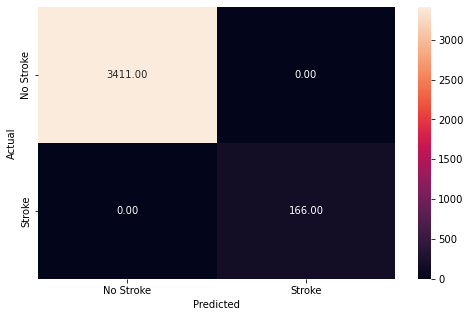

In [24]:
# Making sure model is working. 
y_pred_train = Dtree.predict(X_train)
metrics_score(y_train, y_pred_train)

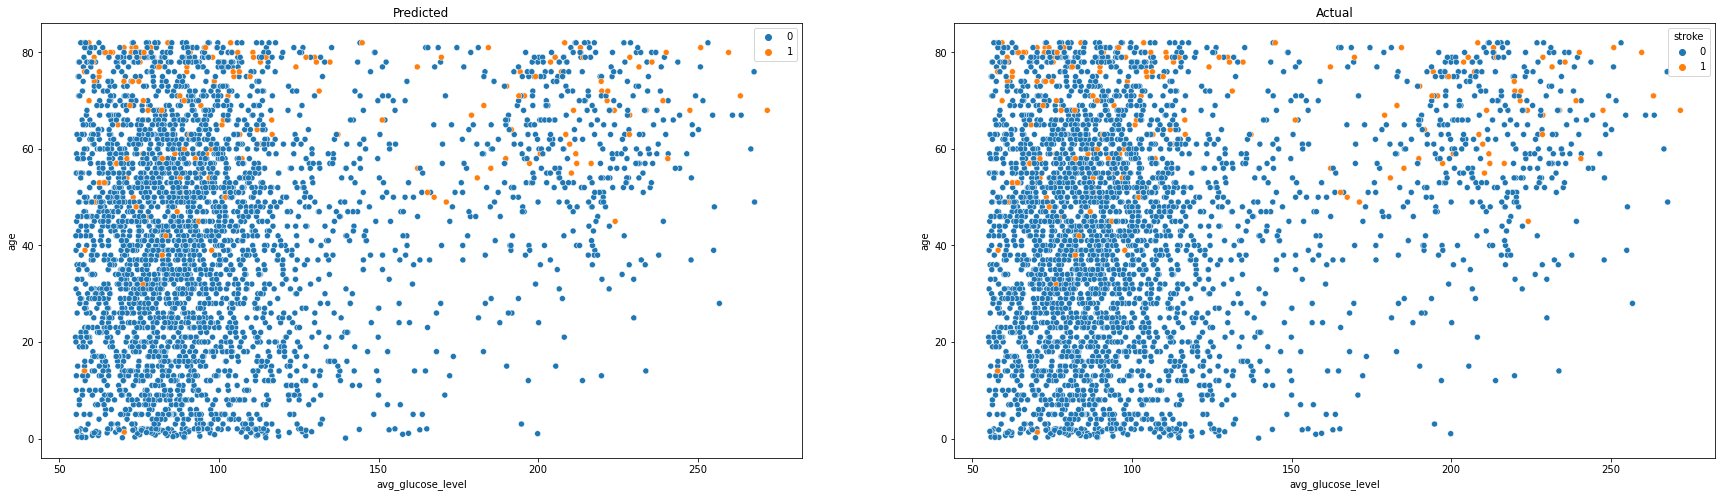

In [25]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_train).set_title("Actual")
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1450
           1       0.19      0.14      0.17        83

    accuracy                           0.92      1533
   macro avg       0.57      0.56      0.56      1533
weighted avg       0.91      0.92      0.92      1533



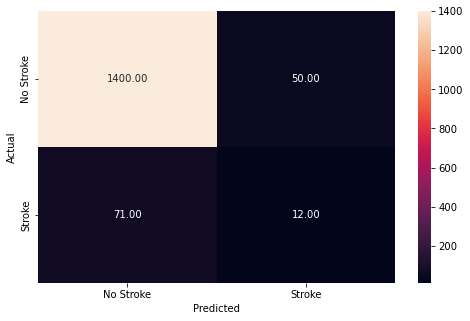

In [26]:
# Check on test data. 
y_pred_test = Dtree.predict(X_test)
metrics_score(y_test, y_pred_test)


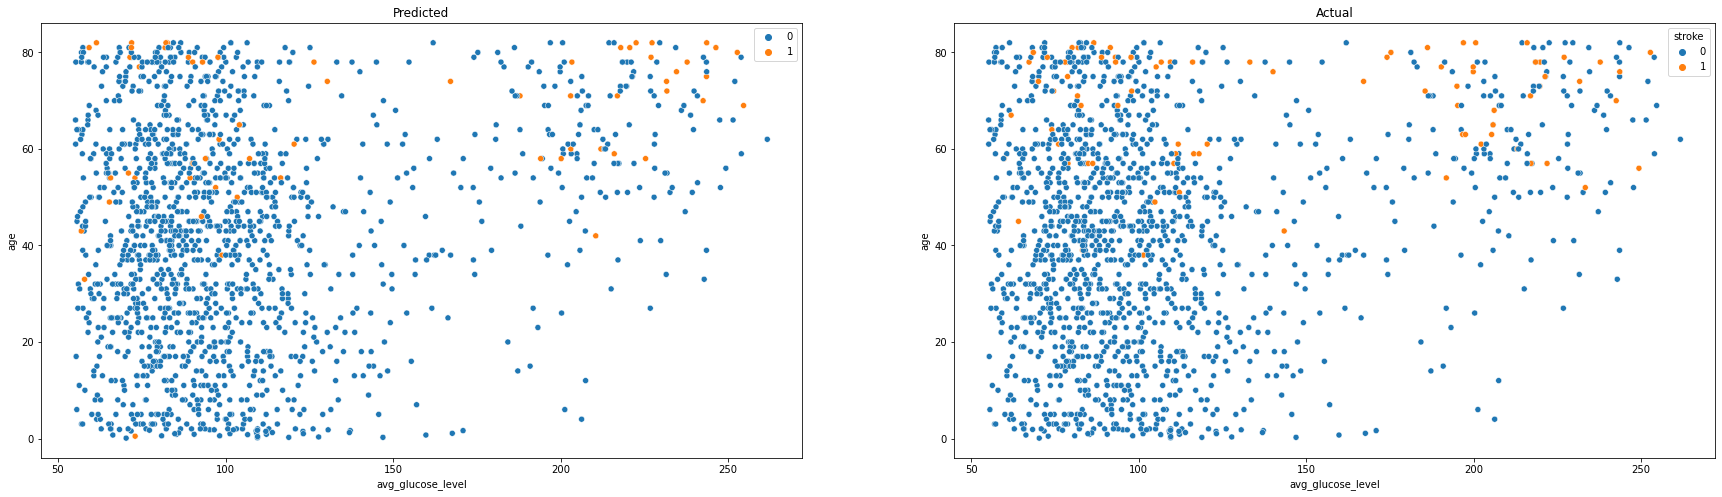

In [27]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_test).set_title("Actual")
plt.show()

* Clearly overfitted. Note that the accuracy isn't as important as the recall score.
* This dataset is being hindered by the fact that there are only a few stroke patients in the set. The stroke parameters are too narrow. 
* What we want most of all is that we don't want to misdiagnose non-strokes. 

In [28]:
from sklearn.model_selection import GridSearchCV

d_tree_tune = DecisionTreeClassifier(random_state = 1, class_weight = "balanced")

parameters = {'max_depth': np.arange(2,7),
              'criterion':['gini', 'entropy'],
              'min_samples_leaf': [5,10,15]
             }

scorer = metrics.make_scorer(recall_score)
grid_obj = GridSearchCV(d_tree_tune, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

d_tree_tuned = grid_obj.best_estimator_

d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, min_samples_leaf=5, random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.51      0.68      3411
           1       0.09      0.96      0.16       166

    accuracy                           0.53      3577
   macro avg       0.54      0.74      0.42      3577
weighted avg       0.95      0.53      0.65      3577



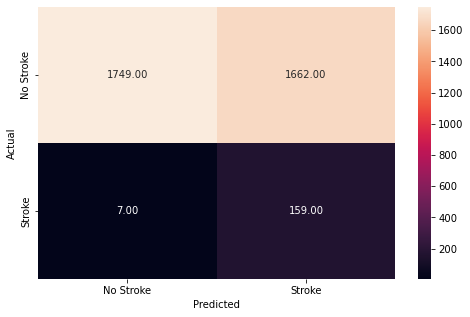

In [29]:
# We check to see how it does on the training set. 
y_pred_train = d_tree_tuned.predict(X_train)
metrics_score(y_train, y_pred_train)

* Though we predict stroke incorrectly much more often the model only misses 7 people that had a stroke when it predicted they wouldn't
* We correctly predict 96% of the stroke victims, but only 51% on non-stroke patients. Overall a 74% isn't great, but considering the amount of stroke patients and how narrow the parameters are for predicting strokes. 

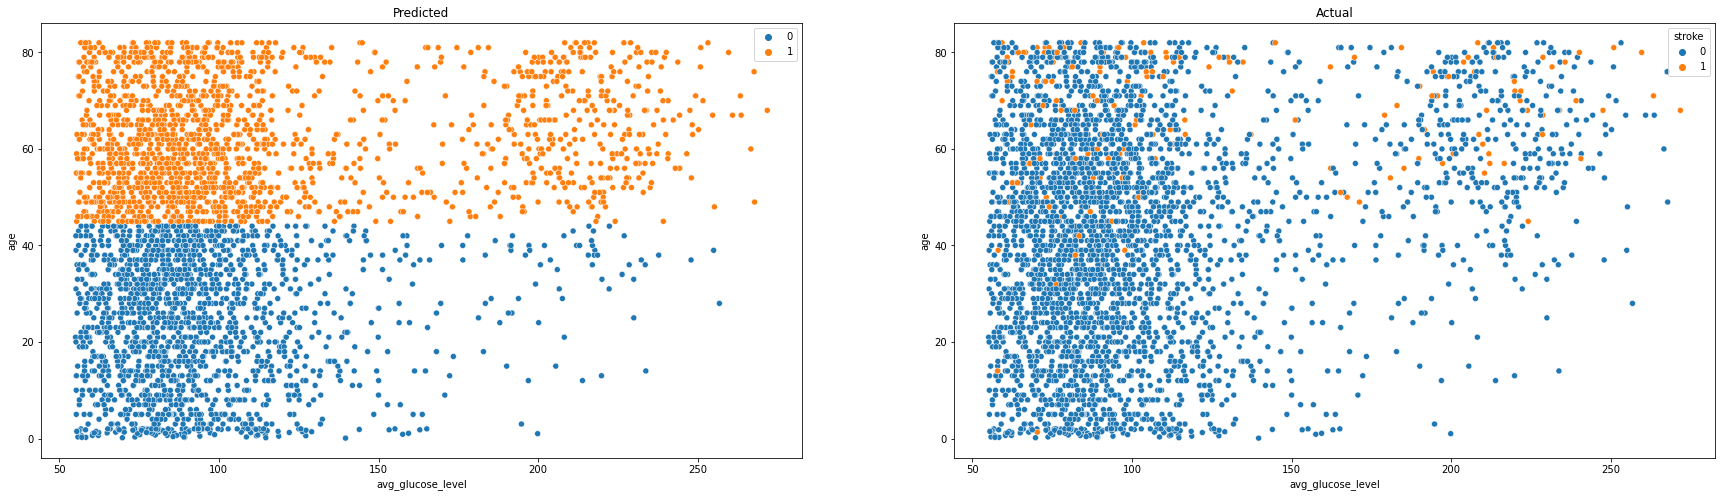

In [30]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_train).set_title("Actual")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.53      0.70      1450
           1       0.11      0.96      0.19        83

    accuracy                           0.56      1533
   macro avg       0.55      0.75      0.44      1533
weighted avg       0.95      0.56      0.67      1533



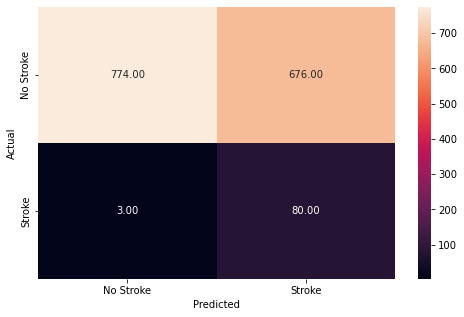

In [31]:
# we now check the test set. 
y_pred_test = d_tree_tuned.predict(X_test)
metrics_score(y_test, y_pred_test)

* Predictions on the test set are still at 96% recall score, a slightly better 53% recall for no stroke.  
* We can safely say the model isn't overfit. 

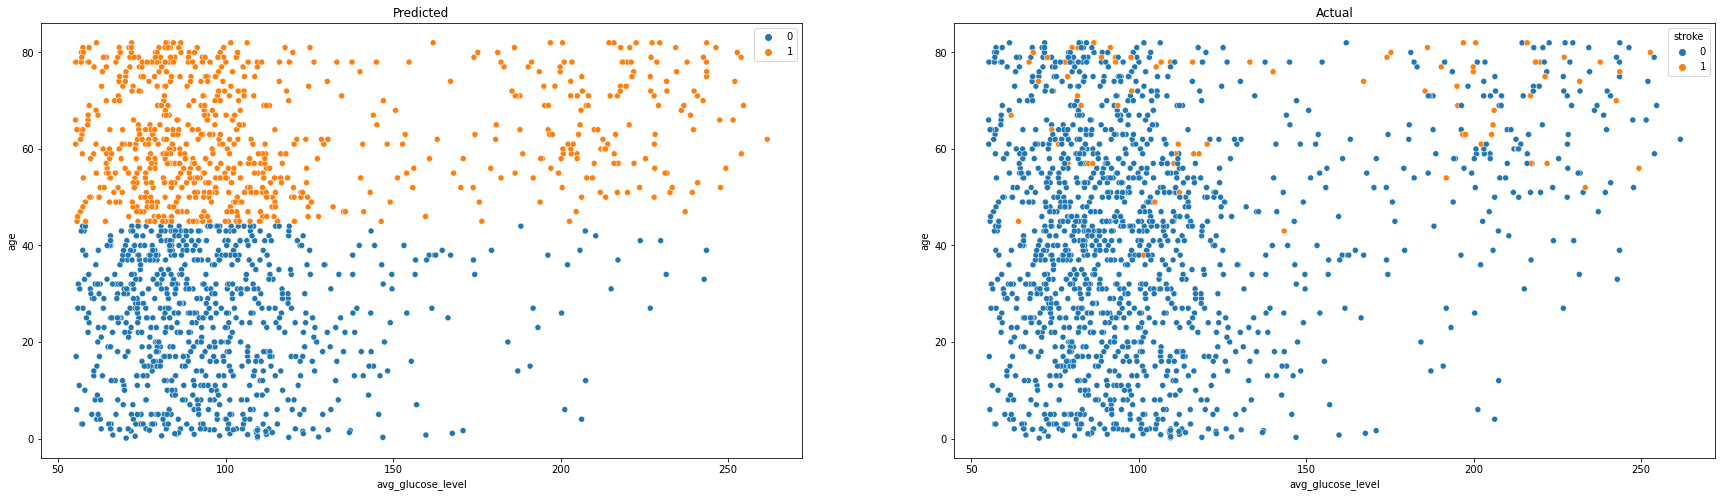

In [32]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_test).set_title("Actual")
plt.show()

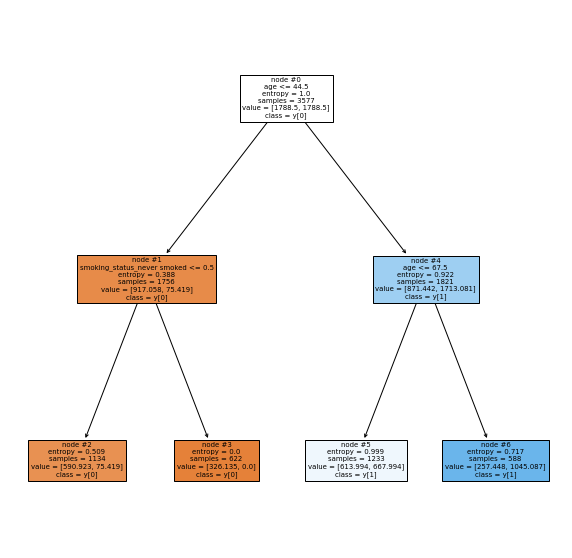

In [33]:
feat = list(X_mean.columns)

plt.figure(figsize=(10,10))
tree.plot_tree(d_tree_tuned, feature_names = feat, filled = True, node_ids = True, class_names = True)
plt.show()

* Age seems to be the biggest precurser.  Over 67.5 seems to be much higher risk.  

In [34]:
print (pd.DataFrame(d_tree_tuned.feature_importances_, columns = ["Importance"], index = X_train.columns).sort_values(by = 'Importance', ascending = False))

                                Importance
age                               0.955514
smoking_status_never smoked       0.044486
work_type_Never_worked            0.000000
smoking_status_formerly smoked    0.000000
Residence_type_Urban              0.000000
work_type_children                0.000000
work_type_Self-employed           0.000000
work_type_Private                 0.000000
gender_Other                      0.000000
hypertension                      0.000000
gender_Male                       0.000000
bmi_imputed                       0.000000
bmi                               0.000000
avg_glucose_level                 0.000000
ever_married                      0.000000
heart_disease                     0.000000
smoking_status_smokes             0.000000


* As we've seen Age is the most important facter in predicting a stroke. 

### Random Forest

In [35]:
rf = RandomForestClassifier(class_weight = "balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411
           1       1.00      1.00      1.00       166

    accuracy                           1.00      3577
   macro avg       1.00      1.00      1.00      3577
weighted avg       1.00      1.00      1.00      3577



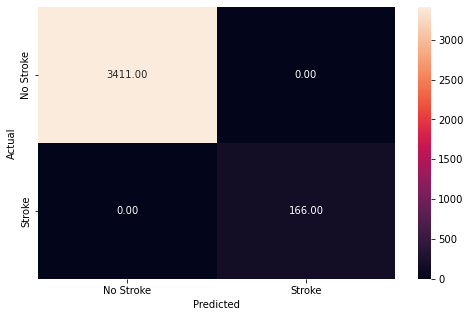

In [36]:
# Check to see if it runs correctly. 
y_pred_train = rf.predict(X_train)
metrics_score(y_train, y_pred_train)

* Random Forest seems to run ok. Certainly overfit. 

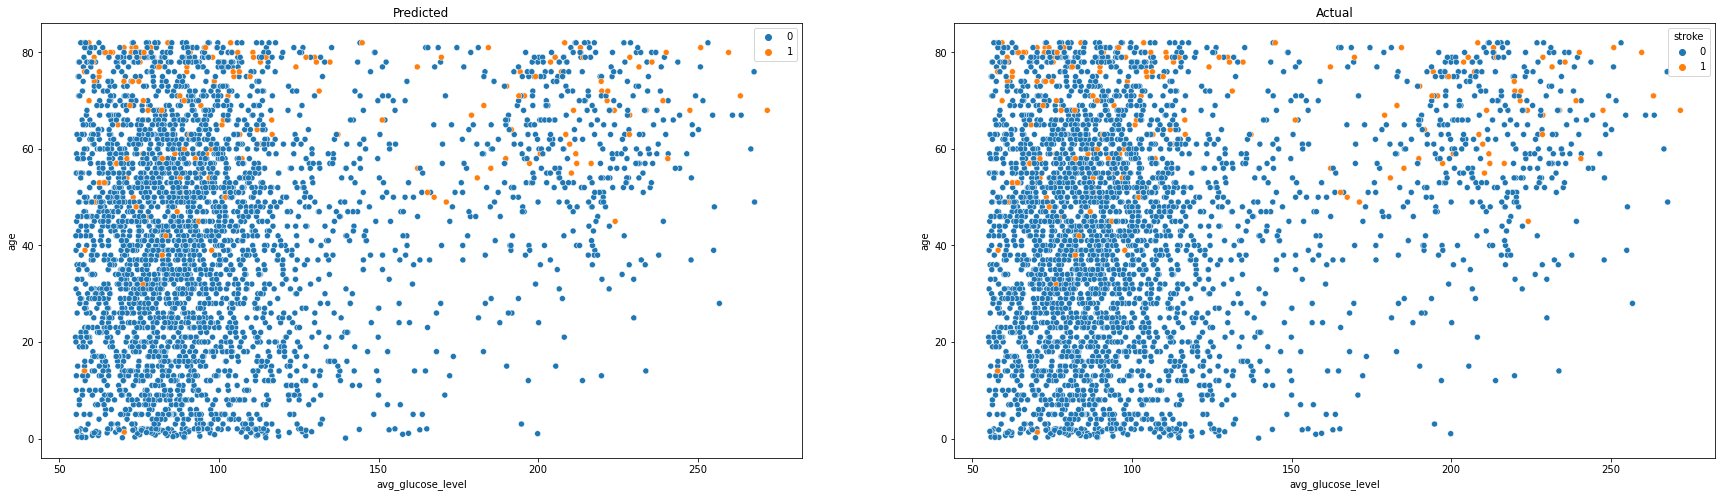

In [37]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_train).set_title("Actual")
plt.show()

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1450
           1       0.20      0.01      0.02        83

    accuracy                           0.94      1533
   macro avg       0.57      0.50      0.50      1533
weighted avg       0.91      0.94      0.92      1533



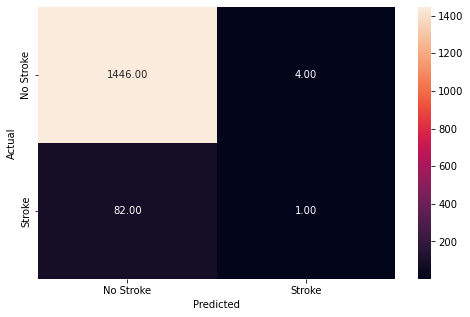

In [38]:
# see how the model does on the test set
y_pred_test = rf.predict(X_test)
metrics_score(y_test, y_pred_test)

* Clearly overfit to the training set.  We are looking the recall metric which is terrible here. 
* Recall score is terrible.

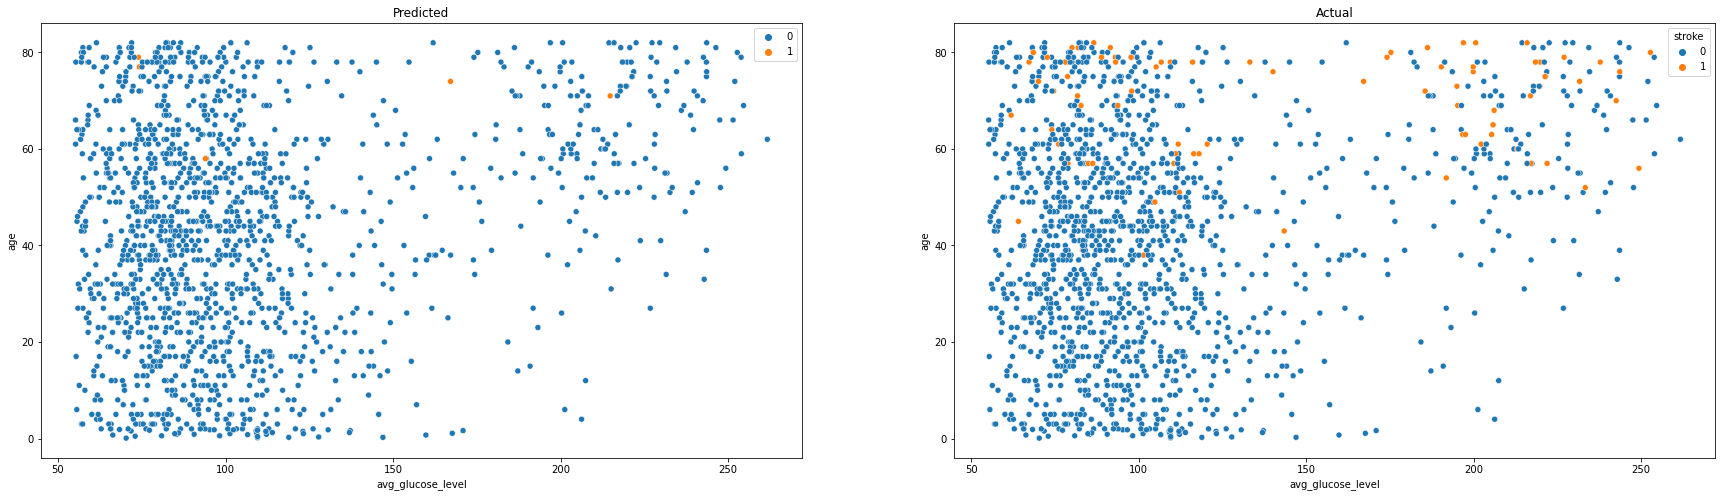

In [39]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_test).set_title("Actual")
plt.show()

In [40]:
rf_tuned = RandomForestClassifier(criterion = "entropy", random_state = 1, class_weight = "balanced")
parameters = {"n_estimators":[50,100,120],
              "max_depth":[4,5,6,7],
              "max_features":[.8,.9,1]}

# Using recall as the metric
scorer = metrics.make_scorer(recall_score)

grid = GridSearchCV(rf_tuned, parameters, scoring = scorer, cv = 5)

grid = grid.fit(X_train, y_train)
rf_tuned = grid.best_estimator_

In [41]:
#fit tuned model to the training data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features=0.9, n_estimators=50,
                       random_state=1)

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      3411
           1       0.15      0.81      0.25       166

    accuracy                           0.78      3577
   macro avg       0.57      0.79      0.56      3577
weighted avg       0.95      0.78      0.84      3577



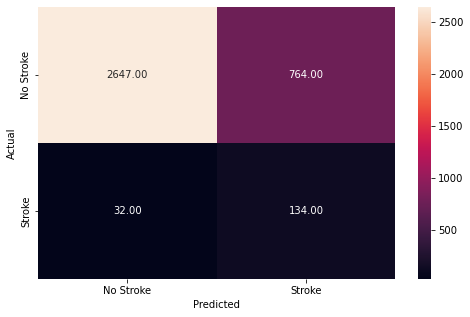

In [42]:
# check to make sure forest runs correctly. 
y_pred_train = rf_tuned.predict(X_train)
metrics_score(y_train, y_pred_train)

* 81% isn't as good as we got with the decision tree, but it seems to be the best overall model so far. 
* This seems to be pretty balanced when it comes to the recall score. 

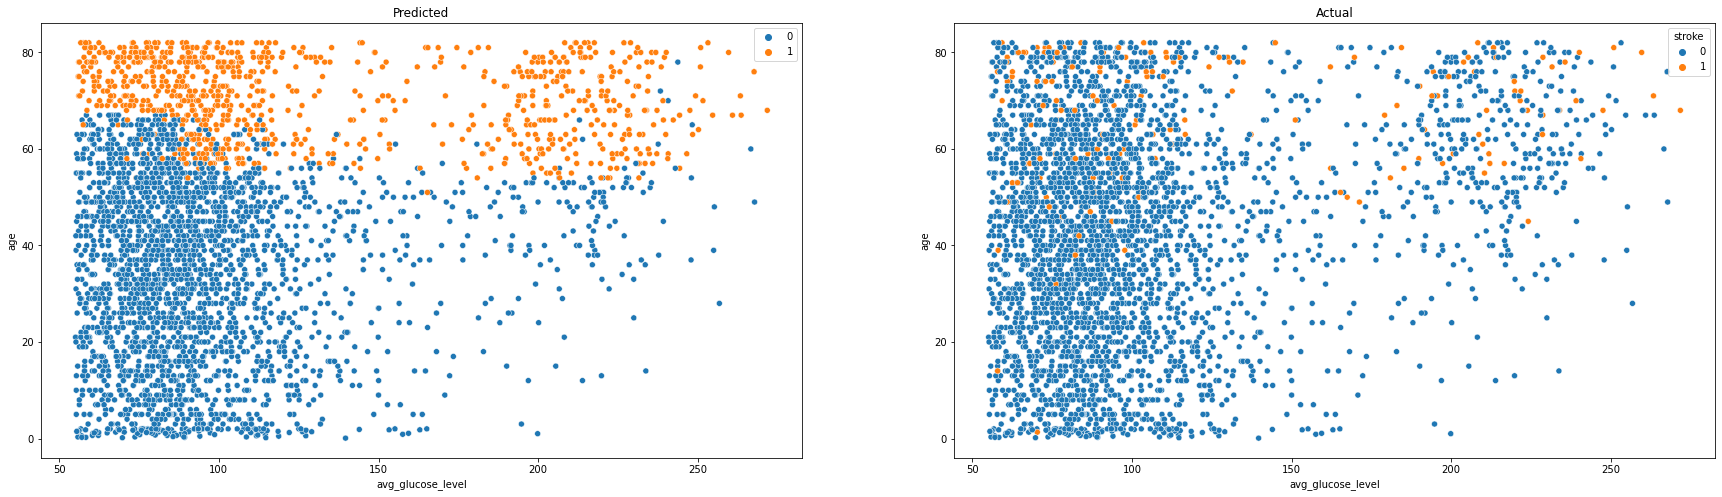

In [43]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_train).set_title("Actual")
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      1450
           1       0.17      0.80      0.28        83

    accuracy                           0.78      1533
   macro avg       0.58      0.78      0.57      1533
weighted avg       0.94      0.78      0.84      1533



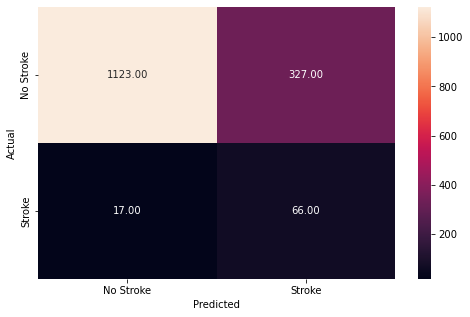

In [44]:
# see how it does on the test set. Expectation is around 80%
y_pred_test = rf_tuned.predict(X_test)
metrics_score(y_test, y_pred_test)

* overall a better model than the decision tree.  Recall score is still a little lower than I'd like to see. 
* Scored an 80% recall but 78% overall.  

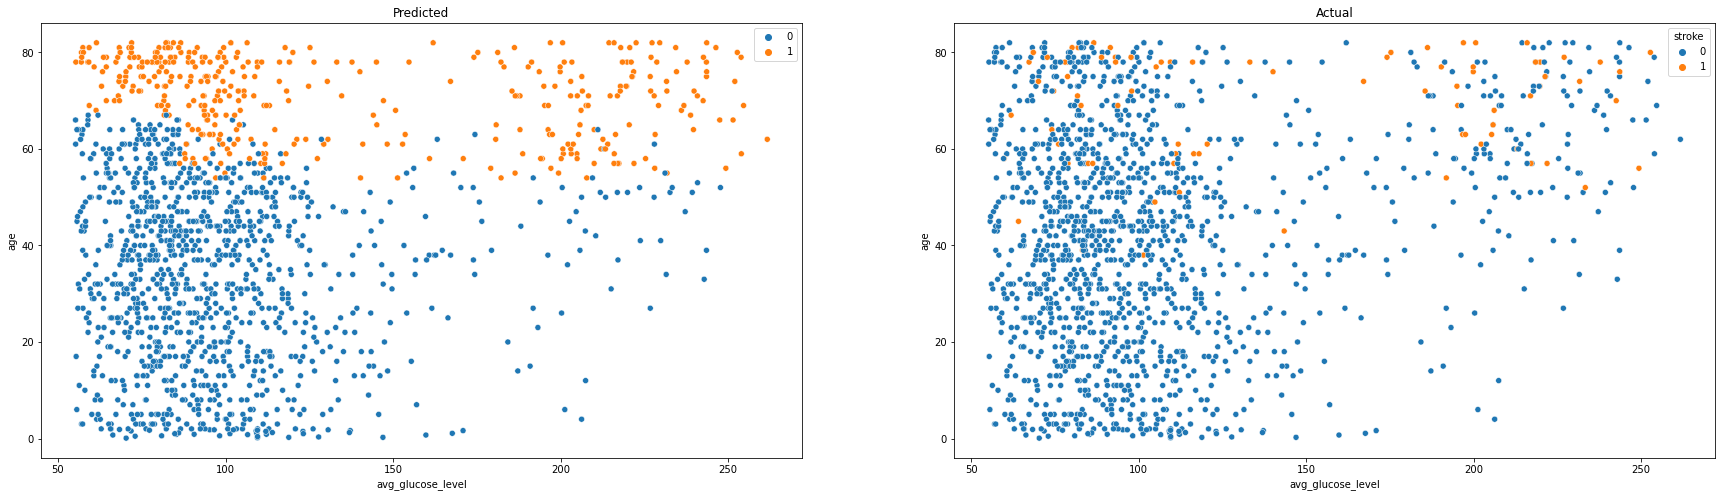

In [45]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test["avg_glucose_level"], y = X_test["age"], hue = y_test).set_title("Actual")
plt.show()

In [46]:
print (pd.DataFrame(rf_tuned.feature_importances_, columns = ["Importance"], index = X_train.columns).sort_values(by = 'Importance', ascending = False))

                                  Importance
age                             7.124716e-01
avg_glucose_level               1.102513e-01
bmi                             6.103167e-02
bmi_imputed                     5.878838e-02
gender_Male                     1.223222e-02
ever_married                    1.055129e-02
work_type_Self-employed         7.969636e-03
smoking_status_smokes           5.290767e-03
hypertension                    5.232878e-03
smoking_status_never smoked     4.578307e-03
heart_disease                   4.011975e-03
work_type_children              3.290525e-03
work_type_Private               2.469229e-03
smoking_status_formerly smoked  1.348659e-03
Residence_type_Urban            4.815711e-04
work_type_Never_worked          5.223330e-17
gender_Other                    0.000000e+00


* Age is still the highest precursor to having a stroke. 
* Glucose, and Bmi are second and third.
* smoking status was second in the decision trees. 

In [47]:
# I want to look at rows where the bmi was imputed. 
data[data["bmi_imputed"]==1]["stroke"].value_counts()


0    161
1     40
Name: stroke, dtype: int64

* I noted this before, but I am noting it again because it came up in the previous model.  Notice 20% of the data points with no bmi listed had a stroke. We compare that to the rest of the data, where the number of people that had a stroke is closer to 5%.  There is a huge discrepancy in these two numbers. This is the reason bmi_imputed is listed as fourth most important feature. 

### KNN model

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# split the data
X_train, X_test, y_train, y_test = train_test_split(X_mean, Y, test_size = .3, random_state = 1)

* The KNN model willl only be done with the bmi data being imputed with mean. 
* This model doesn't seem like it will work well considering how broadly strokes happen.  
* I want to try it anyway to see if it can predict well. 

In [49]:
print(f'Percent of each class in training set: \n{y_train.value_counts(normalize = True)}\n')
print(f'Percent of each class in test set: \n{y_test.value_counts(normalize = True)}')

Percent of each class in training set: 
0    0.953592
1    0.046408
Name: stroke, dtype: float64

Percent of each class in test set: 
0    0.945858
1    0.054142
Name: stroke, dtype: float64


In [50]:
# Normalize each feature.
sc = StandardScaler()
X_train_normal = sc.fit_transform(X_train)
X_test_normal = sc.fit_transform(X_test)

C:\Users\brett\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      0.82      0.88      3411
           1       0.08      0.31      0.12       166

    accuracy                           0.79      3577
   macro avg       0.52      0.57      0.50      3577
weighted avg       0.92      0.79      0.85      3577



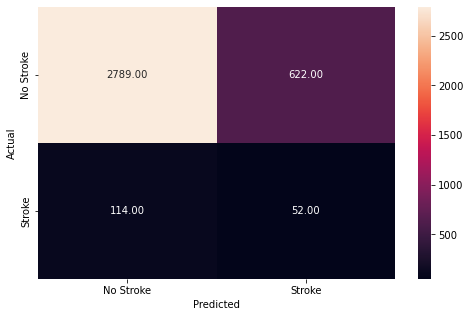

In [51]:
knn = KNeighborsClassifier(weights = "distance", n_neighbors = 3, metric = "euclidean")

knn.fit(X_train_normal, y_train)
y_pred_train = knn.predict(X_train)
metrics_score(y_train, y_pred_train)

* This model doesn't do well, but I didn't expect much.  As we saw in the bivariate analysis, the points are clumped together with points of the opposite category.  

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1450
           1       0.19      0.05      0.08        83

    accuracy                           0.94      1533
   macro avg       0.57      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



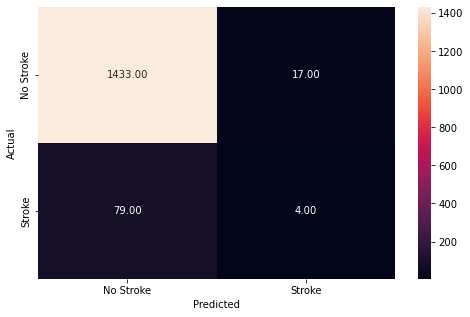

In [52]:
# Running on test set.
y_pred_test = knn.predict(X_test_normal)
metrics_score(y_test, y_pred_test)

* as expected, this model performs poorly.
* It might help to have more stroke patients in the dataset. 

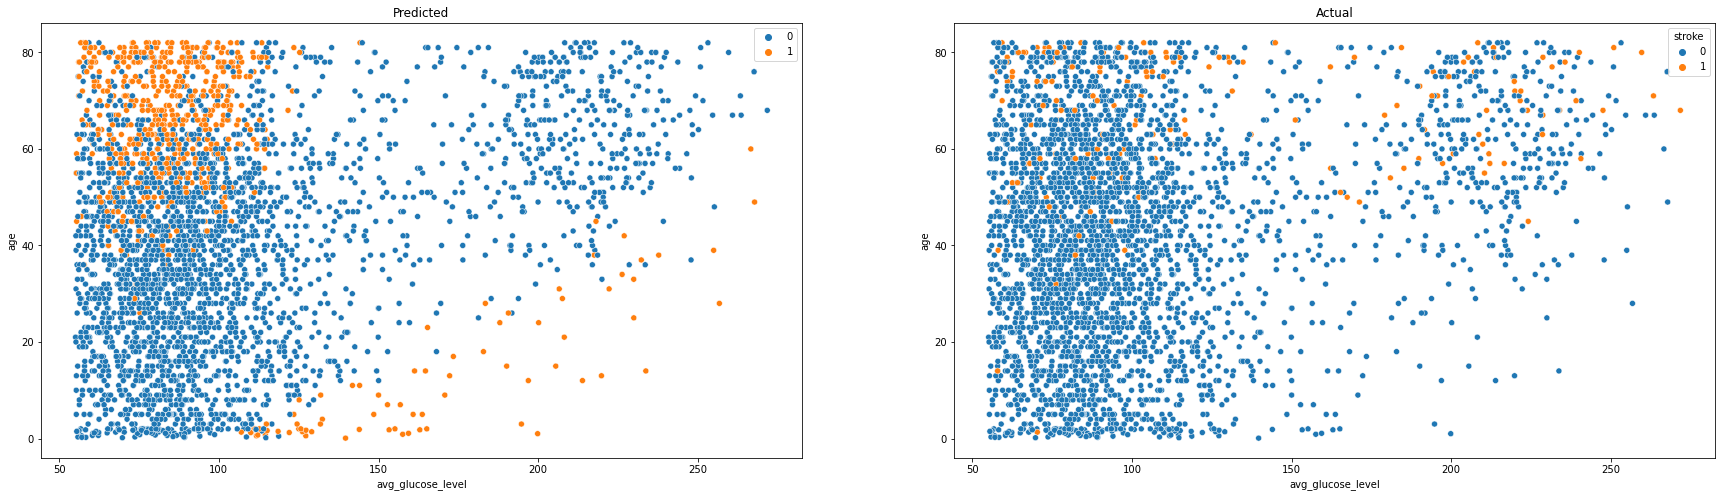

In [53]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_train).set_title("Actual")
plt.show()

### Support Vector Machine

In [54]:
from sklearn import svm


SVM = svm.SVC(class_weight = 'balanced')
SVM.fit(X_train_normal, y_train)

SVC(class_weight='balanced')

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3411
           1       0.22      0.89      0.35       166

    accuracy                           0.85      3577
   macro avg       0.61      0.86      0.63      3577
weighted avg       0.96      0.85      0.89      3577



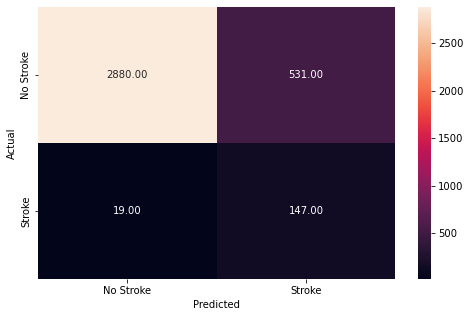

In [55]:
# Checking on training set. 
y_pred_train = SVM.predict(X_train_normal)
metrics_score(y_train, y_pred_train)

* I adjusted the weights, but the number of misdiagnosed Strokes significantly went up, with not much benefit. 

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1450
           1       0.15      0.53      0.23        83

    accuracy                           0.81      1533
   macro avg       0.56      0.68      0.56      1533
weighted avg       0.92      0.81      0.86      1533



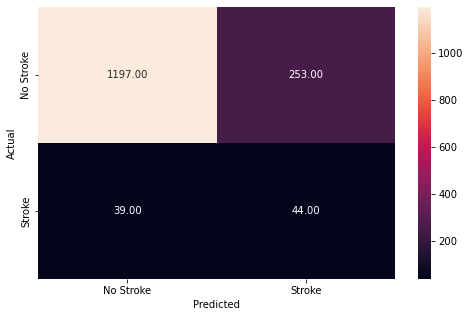

In [56]:
# looking at how the model performs on the test set.
y_pred_test = SVM.predict(X_test_normal)
metrics_score(y_test, y_pred_test)

* The model performed well on the training set, but isn't performing on the test set.  
* we need to adjust some parameters to prevent overfitting. 

In [57]:
SVM_tuned = svm.SVC()
weight = {0:.02, 1:.98}

parameters = {'kernel': ["linear", "poly", "rbf", "sigmoid"],
              'shrinking': [True, False],
              'class_weight':["balanced", weight]
              }
scorer = metrics.make_scorer(recall_score)
grid_obj = GridSearchCV(SVM_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train_normal, y_train)

SVM_tuned = grid_obj.best_estimator_
SVM_tuned.fit(X_train_normal,y_train)

SVC(class_weight={0: 0.02, 1: 0.98}, kernel='sigmoid')

              precision    recall  f1-score   support

           0       0.99      0.46      0.63      3411
           1       0.08      0.92      0.14       166

    accuracy                           0.48      3577
   macro avg       0.53      0.69      0.39      3577
weighted avg       0.95      0.48      0.61      3577



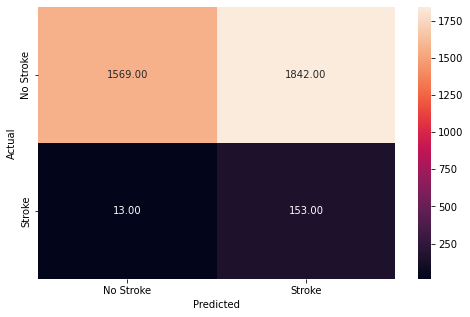

In [58]:
y_pred_train = SVM_tuned.predict(X_train_normal)
metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       1.00      0.47      0.64      1450
           1       0.10      0.98      0.17        83

    accuracy                           0.50      1533
   macro avg       0.55      0.72      0.41      1533
weighted avg       0.95      0.50      0.61      1533



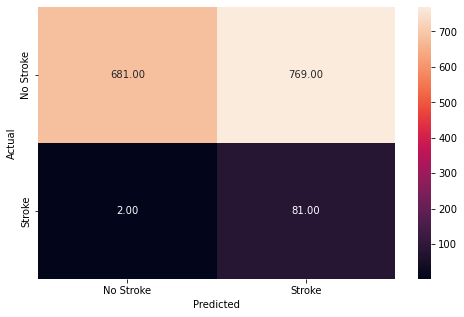

In [59]:
y_pred_test = SVM_tuned.predict(X_test_normal)
metrics_score(y_test, y_pred_test)

* Underperforms both decision tree and random forest.  
* We can increase the recall, but we missdiagnose too many strokes 

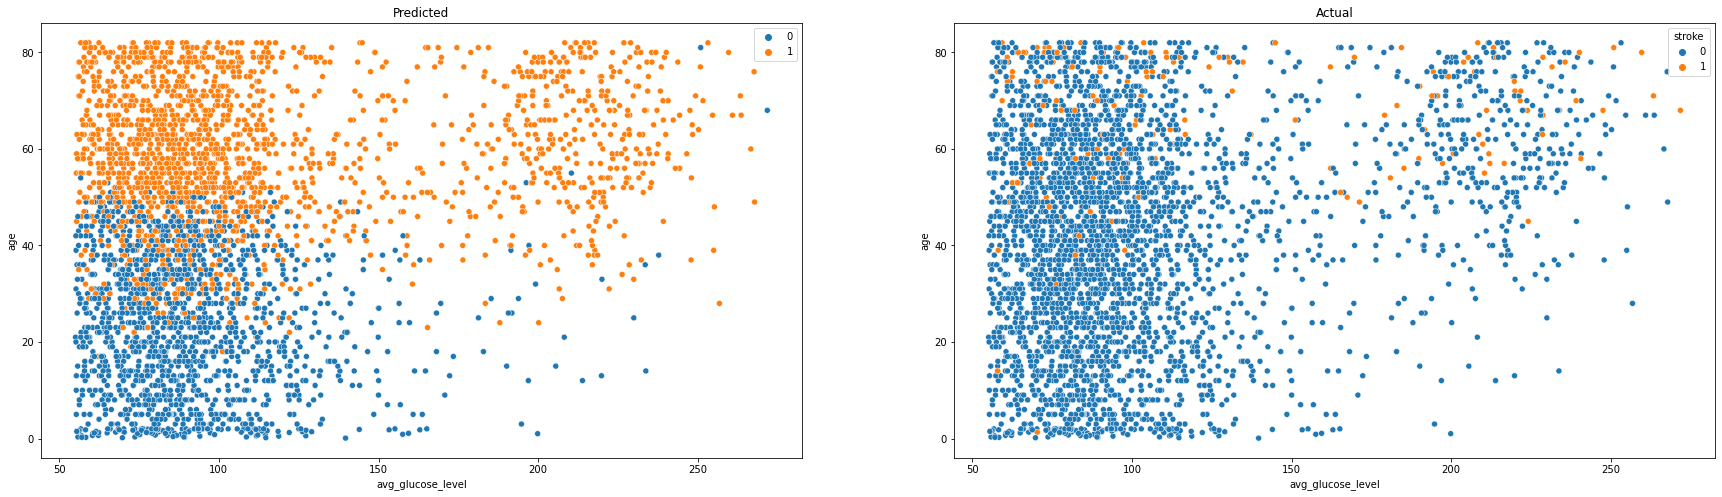

In [60]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train["avg_glucose_level"], y = X_train["age"], hue = y_train).set_title("Actual")
plt.show()

# Notes about dataset
* The split of 5% stroke patients and 95% not stroke is making it a harder to zero in on parameters that lead to a stroke. 
* I will say, even with this disparity, we can reach an 80% prediction. 